In [18]:
#NOESY spectrum performing the simulation in a rotating frame

import sys
sys.path.append('./utils/')
import numpy as np
import scipy.io as spio
from scipy.linalg import expm
import sys 
import json
#import pandas as pd

from basis_utils import read_spinach_info, build_list_ISTs, NormalizeBasis, build_symbolic_list_ISTs,Sz,Sx,Sy,Sz, InnProd
from analytical_fit import get_chemical_shifts, Get_Det_And_Rates ,Get_Det_And_Rates_latex,RelMat_from_ops_and_rates
from simulation_utils import GenNOESYSpectrum, GenH0_Ham,  HamMatRep, sqcosbell_2d_apod, GenFIDsignals
import openfermion as of
from scipy.io import savemat

from matplotlib import pyplot as plt

import copy

In [242]:
def pulse_90xRot(Lx,Ly,ws,t):

    return expm(-1j*(np.pi/2)*(np.cos(ws*t)*Lx+np.sin(ws*t)*Ly))

def pulse_90yRot(Lx,Ly,ws,t):
    return expm(-1j*(np.pi/2)*(-np.sin(ws*t)*Lx+np.cos(ws*t)*Ly))


def GenFIDsignals_Rot(Ham,R,basis,w0,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,Lx,Ly):
    """
    Returns: the FID signals for calculation of NOESY spectrum.
    Args:
    Ham: the target Hamiltonian to simulate, in openfermion format
    R: the relaxation matrix
    w0: the frequecy in w0\sum_{i}S_{z,i}, that defines the rotating frame
    Tpts1, number of time points along dim 1
    Tpst2, number of points along dim 2
    rho0: initial vector to propagate
    coil, the vector that represents the observable to measure to obtain FID (transverse magnetization )
    tmix, mixing time
    dt1, delta of time along dim 1
    dt2, delta of time along dim2
    Lx, \sum_{i}S_{x,i}

    """

    t_grid1= np.linspace(0,(Tpts1-1)*dt1,Tpts1)
    t_grid2 = np.linspace(0,(Tpts2-1)*dt2,Tpts2)

    ###Renormalization of Hamiltonian frequencies
    Nspins = of.count_qubits(Ham)

    Rot_Ham = copy.deepcopy(Ham)

    H0 = of.QubitOperator()

    for i in range(Nspins):
        H0+=w0*Sz(i)
        Rot_Ham+=w0*Sz(i)


    print("The Hamiltonian in the rotating frame is:",Rot_Ham)

    ###Matrix representation of the rotating frame...
    Mat_Rot_Ham = HamMatRep(Rot_Ham,basis,n_qubits=Nspins)

    #Matrix representation of the H0 Hamiltonian
    MatH0 = HamMatRep(H0,basis,n_qubits=Nspins)
    

    #Dim = Ham.shape[0]
    Lnet = Mat_Rot_Ham+1j*R 
    L_dt1 = expm(-1j*Lnet*dt1)
    L_dt2 = expm(-1j*Lnet*dt2)
    pulse_mix = expm(-1j*Lnet*tmix)


    pulse_90x = expm(-1j*Lx*np.pi/2)
    #pulse_90y = expm(-1j*Ly*np.pi/2)
    #pulse_90mx = expm(1j*Lx*np.pi/2)
    #pulse_90my = expm(1j*Ly*np.pi/2)


    #FID_1 = np.zeros([Tpts2,Tpts1],dtype=complex)
    #FID_2 = np.zeros([Tpts2,Tpts1],dtype=complex)
    #FID_3 = np.zeros([Tpts2,Tpts1],dtype=complex)
    #FID_4 = np.zeros([Tpts2,Tpts1],dtype=complex)

    #First 90x pulse:
    rho_t = np.copy(rho0)
    rho_t = np.dot(pulse_90x,rho_t)

    rho_stack = []
    rho_stack.append(rho_t)

    rho_temp = np.copy(rho_t)
    for i in range(1,Tpts1):
        rho_temp = np.dot(L_dt1,rho_temp)
        rho_stack.append(rho_temp)


    rho_stack1_1 = []
    rho_stack1_2 = []
    rho_stack1_3 = []
    rho_stack1_4 = []

    for i in range(Tpts1):
        
        pulse_90_x_t = pulse_90xRot(Lx,Ly,w0,t_grid1[i])
        pulse_90_y_t = pulse_90yRot(Lx,Ly,w0,t_grid1[i])
        pulse_90_x_tm = np.conjugate(np.transpose(pulse_90_x_t))
        pulse_90_y_tm= np.conjugate(np.transpose(pulse_90_y_t))

        pulse_90yRotMix = pulse_90yRot(Lx,Ly,w0,t_grid1[i]+tmix)

        rho_stack1_1.append(pulse_90yRotMix@pulse_mix@pulse_90_x_t@rho_stack[i])
        rho_stack1_2.append(pulse_90yRotMix@pulse_mix@pulse_90_y_t@rho_stack[i])
        rho_stack1_3.append(pulse_90yRotMix@pulse_mix@pulse_90_x_tm@rho_stack[i])
        rho_stack1_4.append(pulse_90yRotMix@pulse_mix@pulse_90_y_tm@rho_stack[i])


    fid_temp_1 = np.zeros([Tpts2,Tpts1],dtype=complex)
    fid_temp_2 = np.zeros([Tpts2,Tpts1],dtype=complex)
    fid_temp_3 = np.zeros([Tpts2,Tpts1],dtype=complex)
    fid_temp_4 = np.zeros([Tpts2,Tpts1],dtype=complex)

    for i in range(Tpts1):
        rho1 = rho_stack1_1[i]
        rho2 = rho_stack1_2[i]
        rho3 = rho_stack1_3[i]
        rho4 = rho_stack1_4[i]

        for j in range(Tpts2):
            #To ensure the invariance of FID under the change of frames, we need to introduce a unitary transform...
            #coil_rot = np.dot(np.transpose(coil),expm(-1j*MatH0*(j*dt2+tmix+dt1*i)))
            coil_rot = expm(-1j*MatH0*(j*dt2+tmix+dt1*i))@coil

            coil_rot = np.transpose(np.conjugate(coil_rot))

            fid_temp_1[j,i] = np.dot(coil_rot,rho1)
            rho1 = L_dt2@rho1

            fid_temp_2[j,i] = np.dot(coil_rot,rho2)
            rho2 = L_dt2@rho2

            fid_temp_3[j,i] = np.dot(coil_rot,rho3)
            rho3 = L_dt2@rho3

            fid_temp_4[j,i] = np.dot(coil_rot,rho4)
            rho4 = L_dt2@rho4
    
    return fid_temp_1, fid_temp_2, fid_temp_3, fid_temp_4


#fid_temp_1, fid_temp_2, fid_temp_3, fid_temp_4 = GenFIDsignals(Ham,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,Lx,Ly)
    
def GenSpec_from_FIDs(fid_temp_1, fid_temp_2, fid_temp_3, fid_temp_4,zerofill1,zerofill2):

    fid_test_cos = fid_temp_1 - fid_temp_3
    fid_test_sin = fid_temp_2 - fid_temp_4

    fid_cos = sqcosbell_2d_apod(fid_test_cos)
    fid_sin = sqcosbell_2d_apod(fid_test_sin)

    f1_cos = np.real(np.fft.fftshift(np.fft.fft2(fid_cos,[zerofill2],[0]),[0]))
    f1_sin = np.real(np.fft.fftshift(np.fft.fft2(fid_sin,[zerofill2],[0]),[0]))


    f1_states = f1_cos-1j*f1_sin

    spectrum = np.fft.fftshift(np.fft.fft2(f1_states,[zerofill1],[1]),[1])
    #if returnFID:
        ###NOTE: return the FID witouth post-processing
    #    return spectrum, fid_test_cos-1j*fid_test_sin
    #else:
    return spectrum


def Ref_NOESY_debug(Ham,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,Lx,Ly):
    
    #Dim = Ham.shape[0]
    Lnet = Ham+1j*R 
    L_dt1 = expm(-1j*Lnet*dt1)
    L_dt2 = expm(-1j*Lnet*dt2)
    pulse_mix = expm(-1j*Lnet*tmix)


    
    pulse_90x = expm(-1j*Lx*np.pi/2)
    pulse_90y = expm(-1j*Ly*np.pi/2)
    pulse_90mx = expm(1j*Lx*np.pi/2)
    pulse_90my = expm(1j*Ly*np.pi/2)


    #FID_1 = np.zeros([Tpts2,Tpts1],dtype=complex)
    #FID_2 = np.zeros([Tpts2,Tpts1],dtype=complex)
    #FID_3 = np.zeros([Tpts2,Tpts1],dtype=complex)
    #FID_4 = np.zeros([Tpts2,Tpts1],dtype=complex)

    #First 90x pulse:
    rho_t = np.copy(rho0)
    rho_t = np.dot(pulse_90x,rho_t)

    rho_stack = []
    rho_stack.append(rho_t)

    rho_temp = np.copy(rho_t)
    for i in range(1,Tpts1):
        rho_temp = np.dot(L_dt1,rho_temp)
        rho_stack.append(rho_temp)


    rho_stack1_1 = []
    rho_stack1_2 = []
    rho_stack1_3 = []
    rho_stack1_4 = []

    for i in range(Tpts1):
        rho_stack1_1.append(pulse_90y@pulse_mix@pulse_90x@rho_stack[i])
        rho_stack1_2.append(pulse_90y@pulse_mix@pulse_90y@rho_stack[i])
        rho_stack1_3.append(pulse_90y@pulse_mix@pulse_90mx@rho_stack[i])
        rho_stack1_4.append(pulse_90y@pulse_mix@pulse_90my@rho_stack[i])

    return rho_stack1_1, rho_stack1_2



In [243]:
#translation of basis format in Spinach to symbolic form
text="""1      (0,0)   (0,0)   
  2      (0,0)   (1,1)   
  3      (0,0)   (1,0)   
  4      (0,0)   (1,-1)  
  5      (1,1)   (0,0)   
  6      (1,1)   (1,1)   
  7      (1,1)   (1,0)   
  8      (1,1)   (1,-1)  
  9      (1,0)   (0,0)   
  10     (1,0)   (1,1)   
  11     (1,0)   (1,0)   
  12     (1,0)   (1,-1)  
  13     (1,-1)  (0,0)   
  14     (1,-1)  (1,1)   
  15     (1,-1)  (1,0)   
  16     (1,-1)  (1,-1)  
"""

data = read_spinach_info(text)

basis = build_list_ISTs(data)
prefacts,Symb_basis = build_symbolic_list_ISTs(data)

#Normbasis = NormalizeBasis(basis,n_qubits=4,checkOrth=True) I have verified the orthonormalization of the basis
Normbasis = NormalizeBasis(basis,n_qubits=2,checkOrth=True)

In [244]:
offset = -46681
B0 = 9.3933
zeeman_scalar_1 = -113.8796
zeeman_scalar_2 = -129.8002
zeeman_scalars = [zeeman_scalar_1,zeeman_scalar_2]
Jcoup = 238.0633
Jcoups = np.zeros([2,2])
Jcoups[0,1] = Jcoup
gammaF = 251814800


#GenH0_Ham(offset,B0,zeeman_scalars,Jcoups,gammaF)

#freqs = [-2996.74,2996.74] # we were missing a factor of 2!
#freqs = [0.0,2*2996.74]
#freqs = [-11968.88/(2*np.pi),6860.19/(2*np.pi)]

#H0_Ham_dfg = GenH0_Ham_allparam(freqs,Jcoups,2)

#zeeman_scalars = [0.0,-15.920]
#zeeman_scalars = [0.0, -15.920599]
#offset=0.0

H0_dfg_ref = GenH0_Ham(offset,B0,zeeman_scalars,Jcoups,gammaF)





In [245]:
#Parameters to perform the simualtion in the rotating frame...

w0 = -6860.1901334*2 ##The factor of 2 is to account for the construction of the Hamiltonian in the Sz basis!


loadMat = spio.loadmat('./data/DFG.mat',squeeze_me=True)

AuxMats = spio.loadmat('./data/DFG_NOESYmatrices.mat',squeeze_me=True)


H = loadMat['p']['H'].item()
R = loadMat['p']['R'].item()
t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()


Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)
Dim = H.shape[0]

rho0 = np.array(AuxMats['rho0'].toarray())
rho0 = rho0.flatten()
coil = AuxMats['coil']


tmix = 0.5
dt1 = 1.1561e-04
dt2 = 1.1561e-04

##Parameters for Fourier transform
zerofill1 = 1024
zerofill2 = 1024

##Definition of pulses in the experiment...
#This also depends on the definition of the basis....
Lx = AuxMats['Lx'].toarray()
Ly = AuxMats['Ly'].toarray()



fid_temp_1, fid_temp_2, fid_temp_3, fid_temp_4 = GenFIDsignals_Rot(H0_dfg_ref,R,Normbasis,w0,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,Lx,Ly)

The Hamiltonian in the rotating frame is: 373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
-18829.07041978772 [Z0] +
373.9489571846715 [Z0 Z1] +
8.69322320795618e-08 [Z1]


In [247]:
ref_fid1, ref_fid2, ref_fid3, ref_fid4 =  GenFIDsignals(H,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,Lx,Ly)

In [251]:
np.linalg.norm(fid_temp_4-ref_fid4)

8.340298390785305e-08

In [190]:
H0_dfg_ref

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
-11968.88028638772 [Z0] +
373.9489571846715 [Z0 Z1] +
6860.190133486933 [Z1]

In [201]:
###For debugging purposes, we check the different phases of the computation...

Ham = H0_dfg_ref


t_grid1= np.linspace(0,(Tpts1-1)*dt1,Tpts1)
t_grid2 = np.linspace(0,(Tpts2-1)*dt2,Tpts2)

###Renormalization of Hamiltonian frequencies
Nspins = of.count_qubits(Ham)

Rot_Ham = copy.deepcopy(Ham)

H0 = of.QubitOperator()

for i in range(Nspins):
    H0+=w0*Sz(i)
    Rot_Ham+=w0*Sz(i)


print("The Hamiltonian in the rotating frame is:",Rot_Ham)

#Matrix representation of Hamiltonian in the original frame...
Mat_Ham = HamMatRep(H0_dfg_ref,Normbasis,n_qubits=Nspins)

###Matrix representation of the rotating frame...
Mat_Rot_Ham = HamMatRep(Rot_Ham,Normbasis,n_qubits=Nspins)

#Matrix representation of the H0 Hamiltonian
MatH0 = HamMatRep(H0,Normbasis,n_qubits=Nspins)

#Dim = Ham.shape[0]
Lnet = Mat_Rot_Ham+1j*R 
L_net_orig = Mat_Ham+1j*R
L_dt1_rot = expm(-1j*Lnet*dt1)
L_dt2_rot = expm(-1j*Lnet*dt2)

L_dt1_orig = expm(-1j*L_net_orig*dt1)
L_dt2_orig = expm(-1j*L_net_orig*dt2)

pulse_mix_rot = expm(-1j*Lnet*tmix)
pulse_mix_orig = expm(-1j*L_net_orig*tmix)


pulse_90x = expm(-1j*Lx*np.pi/2)
pulse_90y = expm(-1j*Ly*np.pi/2)
pulse_90mx = expm(1j*Lx*np.pi/2)
pulse_90my = expm(1j*Ly*np.pi/2)


#FID_1 = np.zeros([Tpts2,Tpts1],dtype=complex)
#FID_2 = np.zeros([Tpts2,Tpts1],dtype=complex)
#FID_3 = np.zeros([Tpts2,Tpts1],dtype=complex)
#FID_4 = np.zeros([Tpts2,Tpts1],dtype=complex)

#First 90x pulse:
rho_t = np.copy(rho0)
rho_t = np.dot(pulse_90x,rho_t)

rho_stack = []
rho_stack.append(rho_t)

rho_temp = np.copy(rho_t)
for i in range(1,Tpts1):
    rho_temp = np.dot(L_dt1_rot,rho_temp)
    rho_stack.append(rho_temp)


rho_stack1_1 = []
rho_stack1_2 = []
rho_stack1_3 = []
rho_stack1_4 = []

for i in range(Tpts1):
    
    pulse_90_x_t = pulse_90xRot(Lx,Ly,w0,t_grid1[i])
    pulse_90_y_t = pulse_90yRot(Lx,Ly,w0,t_grid1[i])
    pulse_90_x_tm = np.conjugate(np.transpose(pulse_90_x_t))
    pulse_90_y_tm= np.conjugate(np.transpose(pulse_90_y_t))

    pulse_90yRotMix = pulse_90yRot(Lx,Ly,w0,t_grid1[i]+tmix)

    rho_stack1_1.append(pulse_90yRotMix@pulse_mix_rot@pulse_90_x_t@rho_stack[i])
    rho_stack1_2.append(pulse_90yRotMix@pulse_mix_rot@pulse_90_y_t@rho_stack[i])
    rho_stack1_3.append(pulse_90yRotMix@pulse_mix_rot@pulse_90_x_tm@rho_stack[i])
    rho_stack1_4.append(pulse_90yRotMix@pulse_mix_rot@pulse_90_y_tm@rho_stack[i])




The Hamiltonian in the rotating frame is: 373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
-18829.07041978772 [Z0] +
373.9489571846715 [Z0 Z1] +
8.69322320795618e-08 [Z1]


In [241]:
#expm(-1j*MatH0*(j*dt2+tmix+dt1*i))

def pulse_90yRot(Lx,Ly,ws,t):
    return expm(-1j*(np.pi/2)*(-np.sin(ws*t)*Lx+np.cos(ws*t)*Ly))

i=0
j=1
pulse_90_x_t = pulse_90xRot(Lx,Ly,w0,dt1*i)
pulse_90_y_t = pulse_90yRot(Lx,Ly,w0,dt1*i)
pulse_90_x_tm = np.conjugate(np.transpose(pulse_90_x_t))
pulse_90_y_tm= np.conjugate(np.transpose(pulse_90_y_t))

pulse_90yRotMix = pulse_90yRot(Lx,Ly,w0,dt1*i+tmix)

#np.linalg.norm(L_dt2_orig@pulse_90y@pulse_mix_orig@pulse_90x@rho_stack[0]-expm(1j*MatH0*(j*dt2+tmix+dt1*i))@L_dt2_rot@pulse_90yRotMix@pulse_mix_rot@pulse_90_x_t@rho_stack[0])

#np.linalg.norm(pulse_90x@rho_stack[0]-pulse_90_x_t@rho_stack[0])
#np.linalg.norm(L_dt2_orig@pulse_90y@pulse_mix_orig-expm(1j*MatH0*(j*dt2+tmix+dt1*i))@L_dt2_rot@pulse_90yRotMix@pulse_mix_rot)

#test =expm(1j*(dt2*j+tmix+i*dt1)*MatH0)@expm(-1j*Lnet*dt2*j)@expm(-1j*MatH0*(tmix+dt1*i))@pulse_90y@expm(1j*MatH0*(tmix+dt1*i))@expm(-1j*Lnet*tmix)@expm(-1j*MatH0*dt1*i)@pulse_90x@expm(1j*MatH0*dt1*i)@expm(-1j*Lnet*dt1*i)

test = expm(1j*(dt2*j+tmix+i*dt1)*MatH0)@expm(-1j*Lnet*dt2*j)@pulse_90yRotMix@expm(-1j*Lnet*tmix)@expm(-1j*MatH0*dt1*i)@pulse_90x@expm(1j*MatH0*dt1*i)@expm(-1j*Lnet*dt1*i)

ref = expm(-1j*L_net_orig*dt2*j)@pulse_90y@expm(-1j*L_net_orig*tmix)@pulse_90x@expm(-1j*L_net_orig*dt1*i)

np.linalg.norm(test-ref)

7.271337980194656e-13

In [240]:
tau=0.1
np.linalg.norm(np.sin(w0*tau)*Lx+np.cos(w0*tau)*Ly-expm(-1j*MatH0*tau)@Ly@expm(1j*MatH0*tau))

5.946255306031164

In [234]:
np.linalg.norm(HamMatRep(Sy(0)+Sy(1),Normbasis)-Ly)

6.280369834735101e-16

In [230]:
pulse_90y = expm(-1j*Ly*np.pi/2)
np.linalg.norm(expm(-1j*MatH0*(tmix+dt1*i))@pulse_90y@expm(1j*MatH0*(tmix+dt1*i))-pulse_90yRot(Lx,Ly,-w0,dt1*i+tmix))
w0

-13720.3802668

In [187]:


tau=1.0
Nspins=2
pulse_90x = expm(-1j*Lx*np.pi/2)

MatHam = HamMatRep(Ham,Normbasis,n_qubits=Nspins)
MatH0 = HamMatRep(H0,Normbasis,n_qubits=Nspins)
Mat_Rot_Ham = HamMatRep(Rot_Ham,Normbasis,n_qubits=Nspins)

Lnet = MatHam+1j*R 
L_dtorig = expm(-1j*Lnet*tau)
L_dt0 = expm(-1j*MatH0*tau)
L_dtRot = expm(-1j*(Mat_Rot_Ham+1j*R)*tau)


pulse_90x_t = pulse_90xRot(Lx,Ly,w0,tau)


#np.linalg.norm(L_dt0@pulse_90x@L_dtorig@rho0-L_dt0@pulse_90x@L_dt0.conj().T@L_dtRot@rho0)

np.linalg.norm(L_dt0@pulse_90x@L_dtorig@rho0-pulse_90x_t@L_dtRot@rho0)


5.896231023102343e-13

6.280369834735101e-16

In [181]:
np.linalg.norm(L_dt0@expm(-1j*(np.pi/2)*Lx)@L_dt0.conj().T-expm(-1j*(np.pi/2)*(np.cos(w0*tau)*Lx+np.sin(w0*tau)*Ly)))

7.2757626474706865e-12

In [179]:
np.linalg.norm(expm(-1j*L_dt0@Lx@L_dt0.conj().T)-expm(-1j*np.cos(w0*tau)*Lx-1j*np.sin(w0*tau)*Ly))

5.870706983545453e-12

In [ ]:
def pulse_90xRot(Lx,Ly,ws,t):

    return expm(-1j*(np.pi/2)*(np.cos(ws*t)*Lx+np.sin(ws*t)*Ly))

In [185]:
tau=1.0
pulse_90x = expm(-1j*(np.pi/2)*Lx)
pulse_90x_t = pulse_90xRot(Lx,Ly,w0,tau)

L_dt0 = expm(-1j*MatH0*tau)
np.linalg.norm(L_dt0@pulse_90x@L_dt0.conj().T - pulse_90x_t)

7.2757626474706865e-12

In [167]:
np.linalg.norm(pulse_90xRot(Lx,Ly,w0,0)-pulse_90x)

0.0

In [162]:

np.linalg.norm(MatHam+MatH0-Mat_Rot_Ham)

2.9331204132176936e-11

In [136]:
Ham

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
-11968.88028638772 [Z0] +
373.9489571846715 [Z0 Z1] +
6860.190133486933 [Z1]

In [134]:
H0

-6860.1901334 [Z0] +
-6860.1901334 [Z1]

In [137]:
Rot_Ham

373.9489571846715 [X0 X1] +
373.9489571846715 [Y0 Y1] +
-18829.07041978772 [Z0] +
373.9489571846715 [Z0 Z1] +
8.69322320795618e-08 [Z1]

In [140]:

np.linalg.norm(MatHam+MatH0-Mat_Rot_Ham)

2.9331204132176936e-11

In [119]:
rho0

array([0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. ])

In [103]:
ref_rho_stack1_1 = Ref_NOESY_debug(H,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,Lx,Ly)

In [110]:
np.dot(np.conjugate(expm(1j*MatH0*tmix)@rho_stack1_1[0]),ref_rho_stack1_1[0])

(-0.1150127204031956+2.4732877302645524e-17j)

In [107]:
np.dot(np.conjugate(rho_stack1_1[0]),ref_rho_stack1_1[0])

(0.1144028062943162-6.77412778267744e-17j)

In [65]:
####Reference FIDS...
ref_fid1, ref_fid2, ref_fid3, ref_fid4 =  GenFIDsignals(Ham,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,Lx,Ly)

In [66]:
np.linalg.norm(ref_fid1)

20.019868021354128

In [67]:
np.linalg.norm(fid_temp_4-ref_fid4)

30.834077401112097

In [42]:
sepc2D = GenSpec_from_FIDs(fid_temp_1, fid_temp_2, fid_temp_3, fid_temp_4,zerofill1,zerofill2)

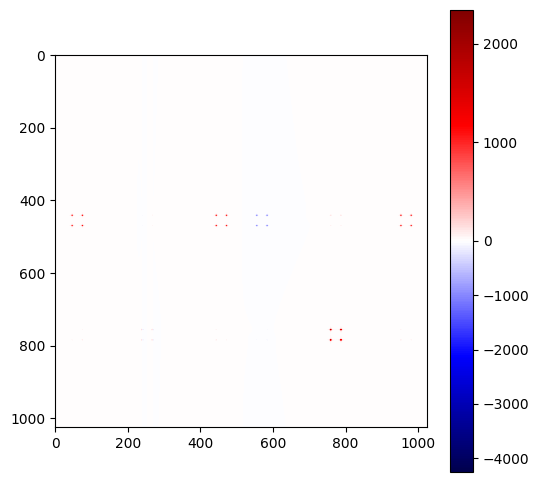

In [43]:
from matplotlib.colors import TwoSlopeNorm

norm = TwoSlopeNorm(vmin=np.min(np.real(sepc2D)), vcenter=0, vmax=np.max(np.real(sepc2D)))

plt.figure(figsize=(6, 6))
plt.imshow(-np.real(sepc2D), cmap='seismic',norm=norm)
plt.colorbar()
plt.show()